In [1]:
import numpy
import skimage.transform
import skimage.color
import skimage.filters
import os
import pickle
import skimage.io
import urllib.request
import json
import pickle
import csv
import random
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import sys
from PIL import Image
from skimage.color import rgb2gray

In [2]:
# define functions for unpack and display segmentation results
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
       This function is reused from the implementation created by Matterport Inc.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    This function is reused from the implementation created by Matterport Inc.

    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    # fig.tight_layout()
    return ax

def display_instances_single(image, boxes, masks, class_ids, class_names, color,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      captions=None):
    """
    This function overlays the segmentation results on the image in a form of contours.
    This function is reused from the implementation created by Matterport Inc.
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    print('#')
    print('#')

    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True


    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = color
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=0.7, linestyle="dashed",
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        #Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    return ax, masked_image

def unpack_mask_indecies(r, padding=None):
    """
    This function unpack the segmentation results.

    Args:
        r[dictionary]: segmentation results including all information
        padding[list]: list of padding sizes

    Returns:
        recon_mask[ndarray, dtype: bool]: a stack of masks of segmented regions
        number_instance[int]: the number of the masks
    """
    masks_size = r['maskssize']
    mask_ori_size = r['masksorisize']
    recon_mask = np.zeros((mask_ori_size[0], mask_ori_size[1], masks_size[2]), dtype=bool)
    masksIdx = r['masksindexori']
    for j in range(0, len(masksIdx)):
        idx = masksIdx[j]
        if padding:
            recon_mask[idx[0]-padding[0][1], idx[1]-padding[1][1], j] = True
        else:
            recon_mask[idx[0], idx[1], j] = True
    number_instance = len(masksIdx)
    return recon_mask, number_instance

def find_matching_nucleus(mask_int, recon_mask2, number_instance2):
    """
    This function finds the nucleus that matches the reference cell by finding the nucleus that have the largest
    overlap of the reference cell.

    Args:
        mask_int[ndarray: dytpe: int]: reference cell mask
        recon_mask2[ndarray, dtype: bool]: a stack of cell masks
        number_instance2[int] : numbers of nucleus masks to loop through

    Returns:
        mask2_nucleus_int[ndarray, dtype: int]: the best matching nucleus mask
    """
    sum_G = []
    for j in range(0, number_instance2):
        mask2 = recon_mask2[:, :, j]
        mask2_int = mask2.astype(int)
        mask_diff = mask_int * mask2_int
        sum_masked = mask_diff.sum()
        sum_G.append(sum_masked)
    id_max = sum_G.index(max(sum_G))
    if sum_G[id_max] > 0:
        mask2_nucleus = recon_mask2[:, :, id_max]
        mask2_nucleus_int = mask2_nucleus.astype(int)
    else:
        mask2_nucleus_int = np.zeros((recon_mask2.shape[0], recon_mask2.shape[1]), dtype=int)
    return mask2_nucleus_int

def compute_maskedregion_metric(mask_image, mask_int):
    """
    This function computes some of the the cellular statistics.

    Args:
        mask_image[ndarray, dtype:int 32]: testing image masked by the mask_int
        mask_int[ndarray, dtype:int 32]: a region mask

    Returns:
        computed cellular metrics for an instance of masked region
    """
    MaxIntensity = np.amax(mask_image)
    MinIntensity = np.amin(mask_image)
    Total = np.sum(mask_image)
    Region = mask_image[np.nonzero(mask_image)]
    Median = np.median(Region)
    Std = np.std(Region)
    regionMetrics = skimage.measure.regionprops(mask_int)
    try:
        area = regionMetrics[0].area
        Mean = Total / area
    except:
        area = 0
        Mean = float('nan')
    return MaxIntensity, Total, Median, Std, Mean, area


In [3]:
# define default names for output files
NucleiResultName = ["NucleiName"]
CellResultName = ["CellName"]
MetricFileName = ["BiomarkerMetric"]

In [6]:
infer_name = "/home/ext_gnanaolivu_rohandavid_mayo_e/deepcseg/data/tissuenet_test_images/20191121_MIBI_whole_cell_breast_Breast_184/cell_result.dat"
infer2_name = "/home/ext_gnanaolivu_rohandavid_mayo_e/deepcseg/data/tissuenet_test_images/20191121_MIBI_whole_cell_breast_Breast_184/nuclei_result.dat"
image_name = "/home/ext_gnanaolivu_rohandavid_mayo_e/deepcseg/data/tissuenet_test_images/20191121_MIBI_whole_cell_breast_Breast_184/image.dat"
image_bio_name = "/home/ext_gnanaolivu_rohandavid_mayo_e/deepcseg/data/tissuenet_test_images/20191121_MIBI_whole_cell_breast_Breast_184/imagebio.dat"

In [7]:
# retrieving the the results generated from the executable (core algorithm)
with open(infer_name, 'rb') as a:
    r = pickle.load(a)               # loading cell segmentation results
with open(infer2_name, 'rb') as b:
    r2 = pickle.load(b)              # loading nucleus segmentation results
with open(image_name, 'rb') as e:
    image = pickle.load(e)           # loading synthesized color image
with open(image_bio_name, 'rb') as f:
    image_bio = pickle.load(f)       # loading biomarker image for displaying

In [8]:
# unpack the mask indices. recon_mask is mask indices for segmented cells, recon_mask2 is for segmented nuclei
recon_mask, number_instance = unpack_mask_indecies(r)     # unpack cell segmentation results
recon_mask2, number_instance2 = unpack_mask_indecies(r2)  # unpack nucleus segmentation results

display results
#
#
#
#


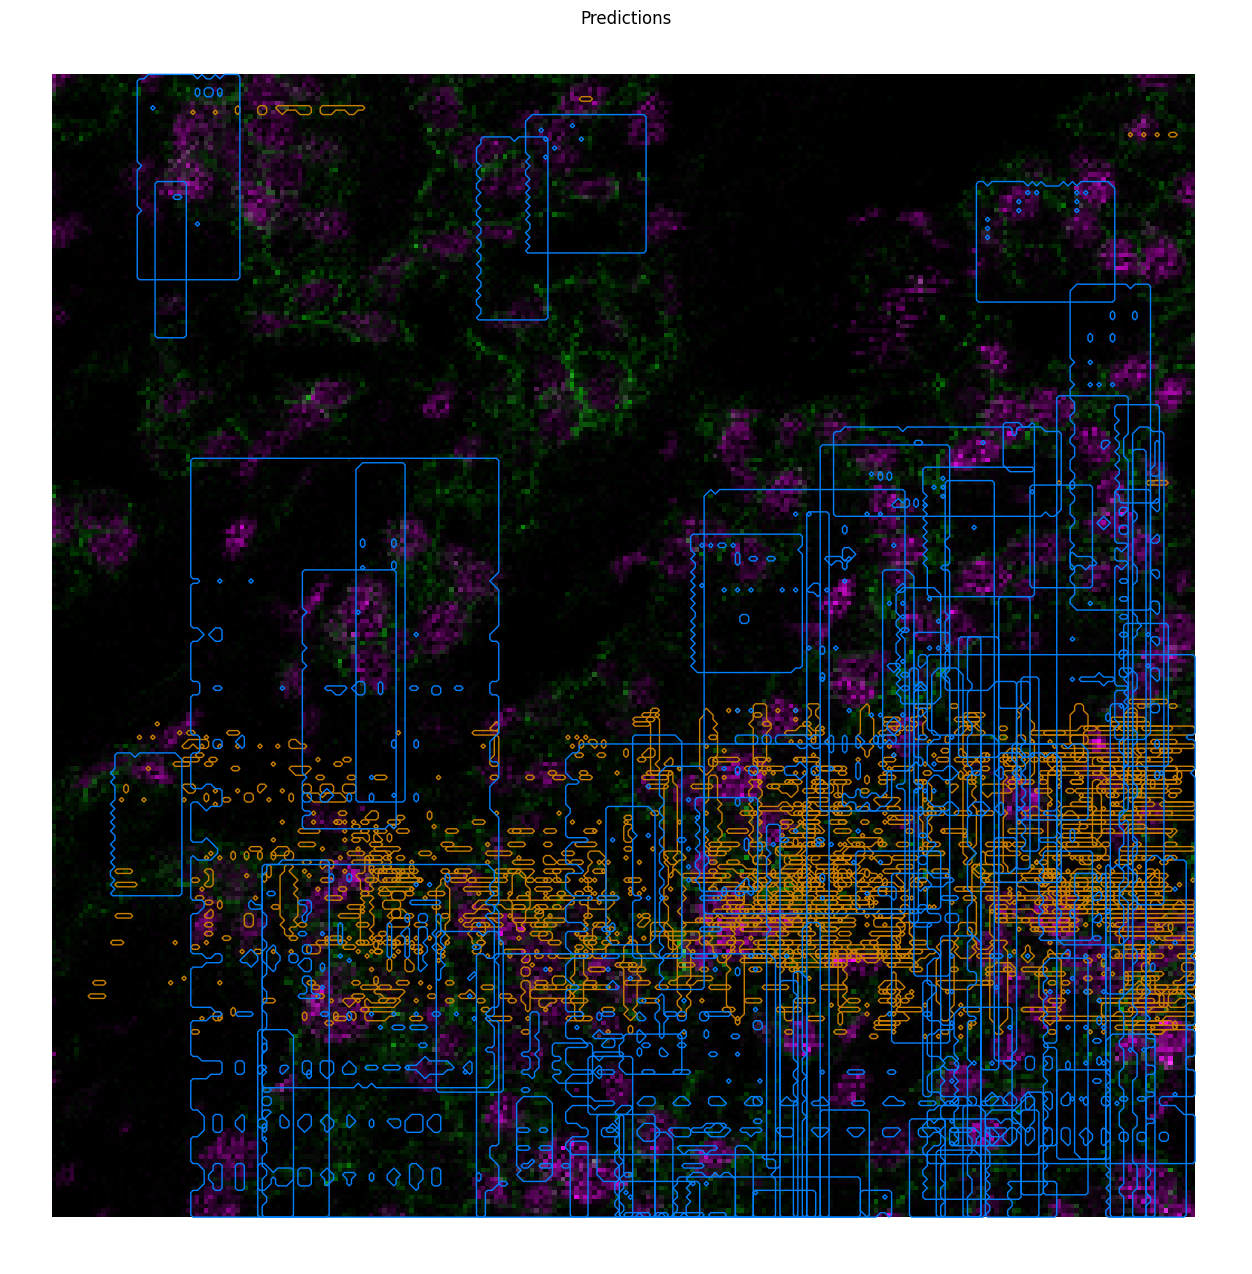

display successfully


In [10]:
print('display results')
color = (0.8, 0.5, 0.0)   # defining cell segmentation contour color (orange) for display
# overlay cell segmentation contours on the color image
ax1, images = display_instances_single(image, r['rois'], recon_mask, r['class_ids'],
                                        ['background', 'cell'], color, None, ax=get_ax(1),
                                        show_bbox=False, show_mask=False,
                                        title="Predictions")
color = (0.0, 0.5, 1.0)   # defining nucleus segmentation contour color (blue) for display
# overlay nucleus segmentation contours on the color image
ax2, marked_image = display_instances_single(image, r2['rois'], recon_mask2, r2['class_ids'],
                                                ['background', 'cell'], color, None, ax=ax1,
                                                show_bbox=False, show_mask=False,
                                                title="Predictions")
brightness_factor =5.5  # You can increase or decrease this factor
images_bright = np.clip(images * brightness_factor, 0, 255).astype(np.uint8)
ax2.imshow(images.astype(np.uint8))
plt.show()
print('display successfully')

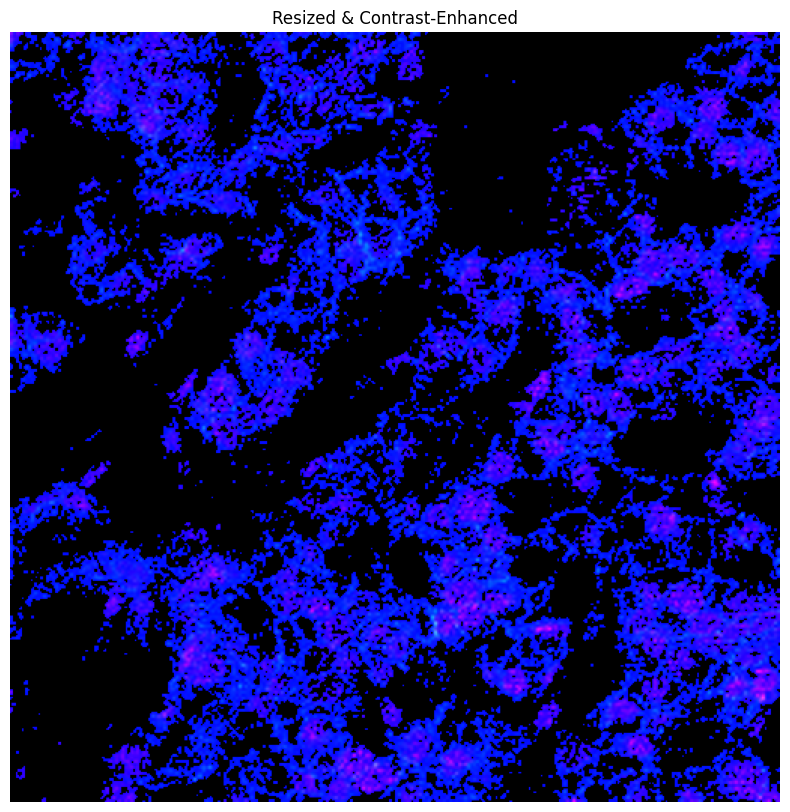

In [11]:
scale_factor = 2  # Change this as needed
test_image = '/home/ext_gnanaolivu_rohandavid_mayo_e/deepcseg/data/tissuenet_test_images//images/20191121_MIBI_whole_cell_breast_Breast_184.png'
img = Image.open(test_image)
new_size = (img.size[0] * scale_factor, img.size[1] * scale_factor)
img_resized = img.resize(new_size, Image.BICUBIC)

# Convert to numpy
img_np = np.array(img_resized)

# Background masking
gray = rgb2gray(img_np)
mask = gray > 0.1  # adjust threshold as needed
masked_img = img_np.copy()
masked_img[~mask] = 0

# Contrast stretching
p_low, p_high = np.percentile(masked_img[mask], (5, 99))
stretched = np.clip((masked_img - p_low) * 255.0 / (p_high - p_low), 0, 255).astype(np.uint8)

# Show
plt.figure(figsize=(10, 10))
plt.imshow(stretched)
plt.axis('off')
plt.title("Resized & Contrast-Enhanced")
plt.show()